# Clinical Evaluation

The first two sheets include clinical annotations of all the patients for disease-free survival/recurrence and for overall survival. 

To perform clinical evaluation specific output format should be obtained!
\
These are the columns and their order:
\
Some new columns need to be created and added, e.g. (DISEASE FREE FOR MORE THAN 5 YEARS becomes 1) IFF (DFS_STATUS IS 'DiseaseFree'
 AND DFS_MONTHS IS >60 MONTHS)

In [2]:
%cd ../src

/Users/ivamilojkovic/Breast-Cancer-Analysis/src


In [6]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 4)

df_clinical_dfs = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA-PANCA DFS')
df_clinical_dfs.head()

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971


In [7]:
df_clinical_os = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA PANCA OS')
print(df_clinical_os.shape)
df_clinical_os.head()

(1084, 4)


,Study ID,Patient ID,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,LIVING,11.440971


In [8]:
df_clinical_out_cols = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='EXAMPLE output - OS DFS SUBTYPE').columns
df_clinical_out_cols = df_clinical_out_cols[:-2]
df_clinical_out_cols

Index(['Patient ID', 'DFS_STATUS', 'DFS_MONTHS', 'RECURRED BEFORE 5 YEARS',
       'RECURRED AFTER FIVE YEARS', 'DISEASE FREE FOR LESS THAN 5 YEARS',
       'DISEASE FREE FOR MORE THAN 5 YEARS', 'OS_STATUS', 'OS_MONTHS',
       'DECEASED WITHIN 5 YEARS', 'SUBTYPE', 'IS LUMA',
       'TRAINING OR TESTING?'],
      dtype='object')

In [10]:
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    df_multi = pickle.load(file)

df_multi[['Basal', 'Her2', 'LumA', 'LumB', 'Normal']] = discard_negative_correlations(df_multi[['Basal', 'Her2', 'LumA', 'LumB', 'Normal']])

print(df_multi.shape)
df_multi.head()

(1053, 25159)


,tcga_id,expert_PAM50_subtype,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,ZYX,ZZEF1,ZZZ3,Subtype-from Parker centroids,MaxCorr,Basal,Her2,LumA,LumB,Normal
0,TCGA-3C-AAAU,LumA,57898,67829,134,1697402,44314,1737,568,0,...,1054121,557596,409660,LumA,0.373445,0.0,0.000000,0.373445,0.179928,0.000000
1,TCGA-3C-AALI,Her2,52146,65152,1361,1403901,36852,1636,1357,41,...,1041074,247545,88163,Her2,0.647827,0.0,0.647827,0.000000,0.247731,0.000000
2,TCGA-3C-AALJ,LumB,52172,29356,510,989281,30378,282,1974,119,...,613785,110466,68745,LumB,0.357503,0.0,0.000000,0.144970,0.357503,0.000000
3,TCGA-3C-AALK,LumA,50517,43436,287,2674831,69374,816,2084,172,...,1397623,196615,206477,LumA,0.666747,0.0,0.000000,0.666747,0.000000,0.458535
4,TCGA-4H-AAAK,LumA,66433,66229,192,2279532,56667,1603,2425,246,...,970767,199472,246179,LumA,0.556303,0.0,0.000000,0.556303,0.000000,0.503962


In [12]:
# Merge the dataframes based on the 'ID' column
merged_df = pd.merge(df_clinical_dfs, df_clinical_os, on=['Patient ID', 'Study ID'])
merged_df

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971
...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569


In [13]:
merged_df['OS_STATUS'].unique()

array(['LIVING', 'DECEASED', nan], dtype=object)

In [14]:
# Add new columns
merged_df['DISEASE FREE FOR MORE THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['DISEASE FREE FOR LESS THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] <= 5*12)
merged_df['RECURRED AFTER 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['RECURRED BEFORE 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] <= 5*12)
merged_df['DECEASED WITHIN 5 YEARS'] = (merged_df['OS_STATUS'] == 'DECEASED') & (merged_df['OS_MONTHS'] <= 5*12)
merged_df

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958,False,False,False,False,False
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819,False,True,False,False,False
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256,False,True,False,False,False
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660,False,True,False,False,False
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569,False,False,False,False,False


In [15]:
df_multi.rename(columns={'tcga_id': 'Patient ID'}, inplace=True)
df_out_1 = pd.merge(df_multi, merged_df, on='Patient ID', how='left')
df_out_1.drop(columns=df_out_1.columns[2:-9], inplace=True)
df_out_1

,Patient ID,expert_PAM50_subtype,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
3,TCGA-3C-AALK,LumA,NaN,NaN,LIVING,47.604958,False,False,False,False,False
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False


In [16]:
df_out_1.isna().sum(axis=0)

Patient ID                              0
expert_PAM50_subtype                    0
DFS_STATUS                            140
DFS_MONTHS                            141
OS_STATUS                               5
OS_MONTHS                               6
DISEASE FREE FOR MORE THAN 5 YEARS      5
DISEASE FREE FOR LESS THAN 5 YEARS      5
RECURRED AFTER 5 YEARS                  5
RECURRED BEFORE 5 YEARS                 5
DECEASED WITHIN 5 YEARS                 5
dtype: int64

In [17]:
# Remove NaN rows
df_out_1.dropna(inplace=True)
df_out_1.isna().sum()

Patient ID                            0
expert_PAM50_subtype                  0
DFS_STATUS                            0
DFS_MONTHS                            0
OS_STATUS                             0
OS_MONTHS                             0
DISEASE FREE FOR MORE THAN 5 YEARS    0
DISEASE FREE FOR LESS THAN 5 YEARS    0
RECURRED AFTER 5 YEARS                0
RECURRED BEFORE 5 YEARS               0
DECEASED WITHIN 5 YEARS               0
dtype: int64

In [18]:
df_out_1

,Patient ID,expert_PAM50_subtype,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
7,TCGA-A1-A0SG,LumA,DiseaseFree,14.268337,LIVING,14.268337,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False


## Models' Outputs

Few more columns to be added ('SUBTYPE', 'IS LUMA', 'TRAINING OR TESTING?') this can be obtained only after predictions are made

In [19]:
# Load test data
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    data = pickle.load(file)
    X = data.drop(columns=['expert_PAM50_subtype', 'tcga_id',
                           'Subtype-from Parker centroids',	'MaxCorr',
                            'Basal', 'Her2', 'LumA', 'LumB', 'Normal'], inplace=False)
    y_orig = data.expert_PAM50_subtype
    y_pam50 = data['Subtype-from Parker centroids']

    # Take labels on whole dataset for PAM50
    y_corr = data[['Basal', 'Her2', 'LumA', 'LumB',	'Normal']]
    y_corr_non_neg = discard_negative_correlations(y_corr)

    # M-cut strategy to assign labels on whole dataset
    y_mcut_labels, mcut_threshs = m_cut_strategy_class_assignment(y_corr, non_neg_values=True)
    y_mcut_labels_neg, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=False)
    print('M-cut average and std threshold value: ', np.mean(mcut_threshs), np.std(mcut_threshs))
    
    # Compute labels from two strategies (M-cut and 5th percentile)
    y_mcut_5perc_labels = create_mcut_nth_percentile_labels(
        m_cut_labels=y_mcut_labels,
        correlations=y_corr_non_neg,
        y=y_pam50,
        keep_primary=True,
        N=5
    )
    
    X_train, X_test, \
    y_train_pam50, y_test_pam50, \
    y_train_mcut, y_test_mcut, \
    y_train_orig, y_test_orig, \
    y_train_5perc, y_test_5perc, \
    y_train_corr, y_test_corr = \
        train_test_split(X, y_pam50, y_mcut_labels, y_orig, 
                        y_mcut_5perc_labels, y_corr, test_size=0.3, random_state=1, stratify=y_pam50)

    # Data standardization | normalization
    X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
    X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
    scaler = FunctionTransformer(log_transform)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Feature selection (based on original case)
    best_feat_model = SelectKBest(score_func=f_classif, k=500) 
    best_feat_model.fit(X_train_scaled, y_train_orig)
    df_scores = pd.DataFrame(best_feat_model.scores_)
    df_feats = pd.DataFrame(X.columns)

    featureScores = pd.concat([df_feats, df_scores],axis=1)
    featureScores.columns = ['Feature', 'Score'] 

    selected_feat = featureScores.sort_values(by='Score')[-500:]['Feature']

    X_train_scaled_selected = X_train_scaled[list(selected_feat)]
    X_test_scaled_selected = X_test_scaled[list(selected_feat)]

    # One-hot encoding of original and PAM50 labels
    y_train_orig = pd.get_dummies(y_train_orig)
    y_test_orig = pd.get_dummies(y_test_orig)
    y_train_pam50 = pd.get_dummies(y_train_pam50)
    y_test_pam50 = pd.get_dummies(y_test_pam50)

    # Merged train and test
    X_scaled_selected = pd.concat([X_train_scaled_selected, X_test_scaled_selected], axis=0)
    X_scaled_selected = X_scaled_selected.sort_index()


M-cut average and std threshold value:  0.26995796609241984 0.1231910246227228


In [20]:
test_idx = y_test_5perc.index
test_tcga_idx = df_multi.iloc[test_idx, 0]
test_tcga_idx

34     TCGA-AC-A6IW
786    TCGA-C8-A27A
451    TCGA-AC-A2QI
11     TCGA-A2-A0YE
599    TCGA-D8-A27I
           ...     
995    TCGA-A2-A25B
917    TCGA-C8-A26X
148    TCGA-C8-A8HR
946    TCGA-AN-A0FN
991    TCGA-A1-A0SN
Name: Patient ID, Length: 316, dtype: object

In [21]:
with open('../models/multi-label_models/ml_best_model_lr03-07-2023_00:31:05.pkl', 'rb') as f:
    model_xgb_br = pickle.load(f)

with open('../models/multi-label_models/ml_chain_best_model_lr03-07-2023_02:03:48.pkl', 'rb') as f:
    model_xgb_cc = pickle.load(f)

with open('../models/multi-label_models/ml_best_model_lr05-07-2023_00:43:55.pkl', 'rb') as f:
    model_lr_br = pickle.load(f)

with open('../models/multi-label_models/ml_chain_best_model_lr05-07-2023_00:58:18.pkl', 'rb') as f:
    model_lr_cc = pickle.load(f)

with open('../models/multi-label_models/ml_best_model_lr06-07-2023_10:17:57.pkl', 'rb') as f:
    model_svm_lp = pickle.load(f)

with open('../models/multi-label_models/ml_best_model_lr05-07-2023_00:27:34.pkl', 'rb') as f:
    model_rf_lp = pickle.load(f)

In [22]:
## Get the predictions and probabilities for each model and set the original test indices

# XGBoost
xgb_br_preds = model_xgb_br.predict(X_test_scaled_selected).toarray()
xgb_br_preds = pd.DataFrame(xgb_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_cc_preds = model_xgb_cc.predict(X_test_scaled_selected).toarray()
xgb_cc_preds = pd.DataFrame(xgb_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_br_prob_preds = model_xgb_br.predict_proba(X_test_scaled_selected).toarray()
xgb_br_prob_preds = pd.DataFrame(xgb_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_cc_prob_preds = model_xgb_cc.predict_proba(X_test_scaled_selected).toarray()
xgb_cc_prob_preds = pd.DataFrame(xgb_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# Logistic Regression
lr_br_preds = model_lr_br.predict(X_test_scaled_selected).toarray()
lr_br_preds = pd.DataFrame(lr_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_cc_preds = model_lr_cc.predict(X_test_scaled_selected).toarray()
lr_cc_preds = pd.DataFrame(lr_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_br_prob_preds = model_lr_br.predict_proba(X_test_scaled_selected).toarray()
lr_br_prob_preds = pd.DataFrame(lr_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_cc_prob_preds = model_lr_cc.predict_proba(X_test_scaled_selected).toarray()
lr_cc_prob_preds = pd.DataFrame(lr_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# SVM
svm_lp_preds = model_svm_lp.predict(X_test_scaled_selected).toarray()
svm_lp_preds = pd.DataFrame(svm_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

svm_lp_prob_preds = model_svm_lp.predict_proba(X_test_scaled_selected).toarray()
svm_lp_prob_preds = pd.DataFrame(svm_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# Random Forest
rf_lp_preds = model_rf_lp.predict(X_test_scaled_selected).toarray()
rf_lp_preds = pd.DataFrame(rf_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

rf_lp_prob_preds = model_rf_lp.predict_proba(X_test_scaled_selected).toarray()
rf_lp_prob_preds = pd.DataFrame(rf_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)


In [23]:
from multilabel_metrics import semi_relaxed_accuracy, ordered_subset_accuracy, k_orders_subset_accuracy

print('XGBoost Binary Relevance: ', semi_relaxed_accuracy(xgb_br_prob_preds, y_test_pam50))
print('XGBoost Chain Classifier: ', semi_relaxed_accuracy(xgb_cc_prob_preds, y_test_pam50))
print('Logistic Regression Binary Relenace: ', semi_relaxed_accuracy(lr_br_prob_preds, y_test_pam50))
print('Logistic Regression Chain Classifier: ', semi_relaxed_accuracy(lr_cc_prob_preds, y_test_pam50))
print('SVM Label Powerset: ', semi_relaxed_accuracy(svm_lp_prob_preds, y_test_pam50))
print('Random Forest Label Powerset: ', semi_relaxed_accuracy(rf_lp_prob_preds, y_test_pam50))


predictions_5perc = rf_lp_preds
prob_predictions_5perc = rf_lp_prob_preds

print('Ordered subset accuracy: ', ordered_subset_accuracy(
y_test_mcut=y_test_5perc, predictions=predictions_5perc, 
y_test_corr=y_test_corr, prob_predictions=prob_predictions_5perc))
print('Subset accuracy for orders below k=1: ', k_orders_subset_accuracy(
y_test_mcut=y_test_5perc, predictions=predictions_5perc, 
y_test_corr=y_test_corr, prob_predictions=prob_predictions_5perc, k=1))
print('Subset accuracy for orders below k=2: ', k_orders_subset_accuracy(
y_test_mcut=y_test_5perc, predictions=predictions_5perc, 
y_test_corr=y_test_corr, prob_predictions=prob_predictions_5perc, k=2))
print('Subset accuracy for orders below k=3: ', k_orders_subset_accuracy(
y_test_mcut=y_test_5perc, predictions=predictions_5perc, 
y_test_corr=y_test_corr, prob_predictions=prob_predictions_5perc, k=3))



XGBoost Binary Relevance:  0.879746835443038
XGBoost Chain Classifier:  0.8955696202531646
Logistic Regression Binary Relenace:  0.8734177215189873
Logistic Regression Chain Classifier:  0.8765822784810127
SVM Label Powerset:  0.8164556962025317
Random Forest Label Powerset:  0.870253164556962
Ordered subset accuracy:  0.6993670886075949
Subset accuracy for orders below k=1:  0.8607594936708861
Subset accuracy for orders below k=2:  0.7025316455696202
Subset accuracy for orders below k=3:  0.6993670886075949


In [24]:
count_number_of_labels(lr_br_preds)
# count_number_of_labels(lr_cc_preds)

[8, 148, 157, 3, 0, 0]

In [25]:
(svm_lp_preds.sum(axis=1) == 3).sum()

5

In [26]:
count_number_of_labels(svm_lp_preds)

[0, 172, 139, 5, 0, 0]

<Figure size 1200x400 with 0 Axes>

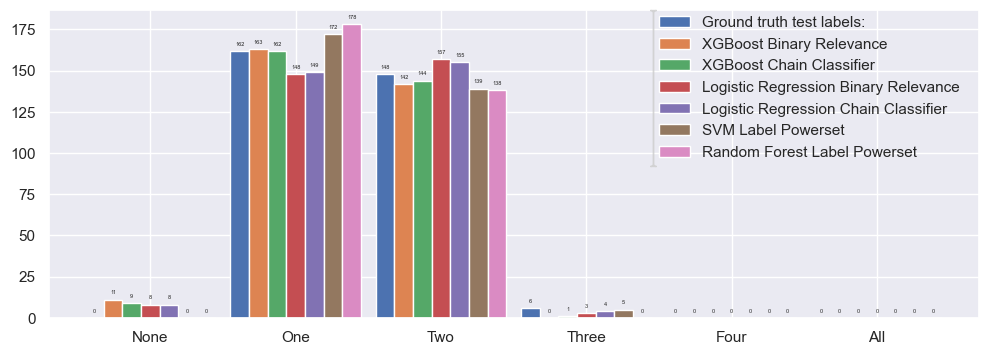

In [27]:
# Barplots for number of labels predicted
ax = plt.figure()
df_lr = pd.DataFrame({
    'Ground truth test labels:': count_number_of_labels(y_test_5perc),
    'XGBoost Binary Relevance': count_number_of_labels(xgb_br_preds),
    'XGBoost Chain Classifier': count_number_of_labels(xgb_cc_preds),
    'Logistic Regression Binary Relevance': count_number_of_labels(lr_br_preds),
    'Logistic Regression Chain Classifier': count_number_of_labels(lr_cc_preds),
    'SVM Label Powerset': count_number_of_labels(svm_lp_preds),
    'Random Forest Label Powerset': count_number_of_labels(rf_lp_preds),
    }, 
    index=['None', 'One', 'Two', 'Three', 'Four', 'All']
)
ax = df_lr.plot(kind='bar', rot=0, width = 0.9)
for g in ax.patches:
    ax.annotate(format(g.get_height(), '.0f'),
                (g.get_x() + g.get_width() / 2, g.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=4)
plt.legend(bbox_to_anchor=(0.65, 1), ncol=1, mode="expand", borderaxespad=0)

## Double check of these results

The strange thing that needs to be further explored is the non-existance of labels for the first 4 models/approaches. Firstly, let's check if the samples that have no labels assigned are similar among these models. 

In [28]:
# Get non-labelled samples
non_label_samples_xgb_br = set(xgb_br_preds[xgb_br_preds.sum(axis=1) == 0].index)
non_label_samples_xgb_cc = set(xgb_cc_preds[xgb_cc_preds.sum(axis=1) == 0].index)
non_label_samples_lr_br = set(lr_br_preds[lr_br_preds.sum(axis=1) == 0].index)
non_label_samples_lr_cc = set(lr_cc_preds[lr_cc_preds.sum(axis=1) == 0].index)

# Intersection
intersection = non_label_samples_xgb_br.intersection(non_label_samples_lr_cc).\
    intersection(non_label_samples_lr_br).intersection(non_label_samples_lr_cc)
intersection = list(intersection)
print("Intersection: ", intersection)

# Union
union = non_label_samples_xgb_br.union(non_label_samples_lr_cc).\
    union(non_label_samples_lr_br).union(non_label_samples_lr_cc)
union = list(union)
print('Union: ', union)

Intersection:  [1034, 306, 147, 117, 186]
Union:  [66, 1034, 715, 716, 723, 147, 917, 930, 226, 306, 436, 117, 822, 889, 186]


In [29]:
df_intersection = df_multi.iloc[intersection, -5:]
df_intersection

,Basal,Her2,LumA,LumB,Normal
1034,0.112605,0.000000,0.000000,0.000000,0.297287
306,0.305354,0.000000,0.000000,0.000000,0.123169
147,0.000000,0.042977,0.011477,0.077839,0.000000
117,0.000000,0.089940,0.078896,0.000000,0.000000
186,0.000000,0.000000,0.143625,0.180504,0.056038


In [30]:
df_union = df_multi.iloc[union, -5:]
df_union

,Basal,Her2,LumA,LumB,Normal
66,0.158800,0.000000,0.000000,0.000000,0.268475
1034,0.112605,0.000000,0.000000,0.000000,0.297287
715,0.023193,0.000000,0.139880,0.000000,0.230444
716,0.000000,0.000000,0.203457,0.078319,0.042305
723,0.000000,0.000000,0.113469,0.515486,0.000000
147,0.000000,0.042977,0.011477,0.077839,0.000000
917,0.000000,0.316879,0.000000,0.000000,0.000000
930,0.000000,0.413109,0.041345,0.000000,0.040096
226,0.000000,0.106651,0.340024,0.039520,0.114142
306,0.305354,0.000000,0.000000,0.000000,0.123169


In [31]:
# Compute average memberships of union samples 
avg_union_memberships = df_union.mean(axis=0)
avg_union_memberships

Basal     0.039997
Her2      0.092940
LumA      0.092242
LumB      0.089508
Normal    0.078130
dtype: float64

In [32]:
# Remove union samples from the original dataset
df_without_union_samples = df_multi.iloc[y_test_5perc.index, -5:].drop(index=df_union.index)
df_without_union_samples


,Basal,Her2,LumA,LumB,Normal
34,0.729748,0.000000,0.000000,0.000000,0.257143
786,0.000000,0.000000,0.000000,0.357023,0.000000
451,0.000000,0.000000,0.793421,0.000000,0.480624
11,0.749244,0.000000,0.000000,0.000000,0.245714
599,0.000000,0.000000,0.732917,0.000000,0.653974
...,...,...,...,...,...
513,0.000000,0.000000,0.717167,0.000000,0.665018
995,0.000000,0.124034,0.000000,0.486483,0.000000
148,0.103866,0.000000,0.195102,0.000000,0.412533
946,0.000000,0.000000,0.615654,0.000000,0.251188


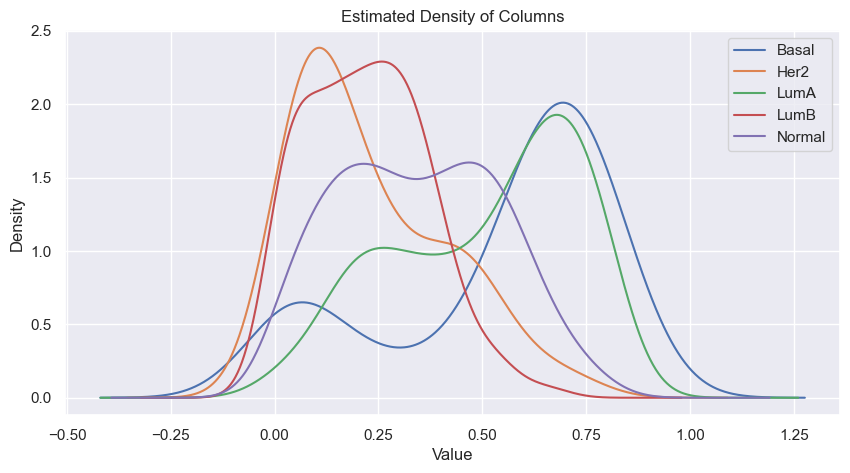

In [33]:
sigma_3s = []

plt.figure(figsize=(10, 5))
for column in df_without_union_samples.columns:
    # Do not conside zero correlations
    label_column = df_without_union_samples[column]
    label_column[label_column>0].plot.kde(label=column)

    # Calculate 3*sigma for each column
    sigma_3 = 3 * np.std(label_column)
    sigma_3s.append(sigma_3)

df_sigma_3 = pd.Series(sigma_3s, index=df_without_union_samples.columns)

plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Estimated Density of Columns')
plt.show()

In [34]:
df_sigma_3

Basal     0.789500
Her2      0.350468
LumA      0.881906
LumB      0.415392
Normal    0.679257
dtype: float64

In [35]:
from scipy.stats import ttest_ind

# Perform T-test for each column
for column in df_union.columns:
    t_stat, p_value = ttest_ind(
        df_union[column], 
        df_without_union_samples[column])

    print("T-statistic " + column + ": ", t_stat)
    print("P-value: " + column + ": ", p_value, '\n')

T-statistic Basal:  -1.266895633369456
P-value: Basal:  0.2061314851311838 

T-statistic Her2:  1.654376732069978
P-value: Her2:  0.09905020944266381 

T-statistic LumA:  -3.6968572987396198
P-value: LumA:  0.0002575309977724625 

T-statistic LumB:  0.16351797126966858
P-value: LumB:  0.8702158189531691 

T-statistic Normal:  -2.7995247042001297
P-value: Normal:  0.00543457731207559 



## Three-labelled samples

In [36]:
# Samples with 3 labels
three_label_test_samples_idx = set(y_test_5perc[y_test_5perc.sum(axis=1) == 3].index)

three_label_test_samples = df_multi.iloc[list(three_label_test_samples_idx), -5:]
three_label_test_samples

,Basal,Her2,LumA,LumB,Normal
6,0.0,0.167827,0.284802,0.419736,0.000000
905,0.0,0.275486,0.150732,0.158415,0.000000
909,0.0,0.232653,0.224970,0.000000,0.154094
751,0.0,0.135270,0.208739,0.314670,0.000000
892,0.0,0.315342,0.197887,0.201825,0.000000
1023,0.0,0.184634,0.196447,0.293637,0.000000


In [37]:
three_label_test_samples_svm_lp_idx = set(svm_lp_preds[svm_lp_preds.sum(axis=1) == 3].index)
three_label_test_samples_svm_lp = df_multi.iloc[list(three_label_test_samples_svm_lp_idx), -5:]
three_label_test_samples_svm_lp

,Basal,Her2,LumA,LumB,Normal
322,0.409460,0.200288,0.000000,0.100312,0.000000
585,0.000000,0.000000,0.487155,0.175990,0.082929
336,0.257623,0.256951,0.000000,0.005234,0.000000
886,0.000000,0.470060,0.103577,0.052677,0.000000
87,0.000000,0.412341,0.030300,0.533349,0.000000


In [38]:
y_test_5perc.loc[three_label_test_samples_svm_lp_idx, :]

,Basal,Her2,LumA,LumB,Normal
322,1,0,0,0,0
585,0,0,1,0,0
336,0,1,0,0,0
886,0,1,0,0,0
87,0,1,0,1,0


In [39]:
svm_lp_preds.loc[three_label_test_samples_svm_lp_idx, :]

,Basal,Her2,LumA,LumB,Normal
322,1,1,0,1,0
585,0,1,1,1,0
336,1,1,0,0,1
886,0,1,1,1,0
87,0,1,1,1,0


# One-labelled samples analysis

In [40]:
# Function to get custom sorted indices for each row
def rank_indices(row):
    return row.rank(ascending=False).astype(int)

def cmp_statistics_for_one_labelled_samples(predictions, gt_labels, df_multi, X_test_scaled_selected):

    # Check dimensions
    assert predictions.shape == gt_labels.shape

    # Set the original indices
    predictions.set_index(gt_labels.index, inplace=True)

    # Get samples's predictions and GTs with only one label
    preds_one_label_idx = predictions.sum(axis=1) == 1
    preds_one_label = predictions[predictions.sum(axis=1) == 1]
    gt_samples_one_label = gt_labels[gt_labels.sum(axis=1) == 1]

    print("Number of 1-labelled samples from GT test set: ", gt_samples_one_label.shape[0])
    print("Number of 1-labelled samples from predicted test set: ", preds_one_label.shape[0])

    # Find the samples with one label that appeared in GT and prediction
    one_label_overlap_idx = set(gt_samples_one_label.index).\
        intersection(set(preds_one_label.index))
    print('Number of samples that overlap:', len(one_label_overlap_idx))

    # Now check how many of them have the exact same label assigned
    overlap = preds_one_label.loc[list(one_label_overlap_idx), :]
    gt_overlap = gt_samples_one_label.loc[list(one_label_overlap_idx), :]
    print('Number of samples correctly predicted: ', len(one_label_overlap_idx) - (overlap != gt_overlap).sum(axis=1).sum())

    # Applying the rank-function to each row of the GT correlation/membership values
    X_corr_test = df_multi.iloc[X_test_scaled_selected.index, -5:]
    ranked_indices = X_corr_test.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=X_corr_test.columns, index=X_corr_test.index)
    assert ranked_corr_df.shape == gt_labels.shape
    ranked_corr_labelled_df = ranked_corr_df * gt_labels

    # Find rows with only one label in the predictions DataFrame
    single_label_rows = predictions.sum(axis=1) == 1

    # Extract corresponding rows from predictions and GT ranks and GT labels
    ranked_for_single_label = ranked_corr_labelled_df[single_label_rows]
    predictions_df = predictions[single_label_rows]
    gt_df = gt_labels[single_label_rows]

    num_complet_correct = ((predictions_df==gt_df).sum(axis=1) == 5).sum()
    print('Number of well predicted:', num_complet_correct)

    # Count how many samples where 1 is in predictions correspond to rank 1 in the ranked DataFrame
    count_ones_at_rank_one = ((ranked_for_single_label == 1) & (predictions_df == 1)).sum().sum()
    # Count how many samples where 1 is in predictions correspond to rank 2 in the ranked DataFrame
    count_ones_at_rank_two = ((ranked_for_single_label == 2) & (predictions_df == 1)).sum().sum()
    # Count how many samples where 1 is in predictions correspond to rank 2 in the ranked DataFrame
    count_ones_at_rank_zero = ((ranked_for_single_label == 0) & (predictions_df == 1)).sum().sum()
    # Count how many samples where 1 is in predictions correspond to rank 2 in the ranked DataFrame
    count_ones_at_rank_three = ((ranked_for_single_label == 3) & (predictions_df == 1)).sum().sum()

    print("Number of samples where 1 is in predictions and corresponds to rank 1 in ranked DataFrame:", count_ones_at_rank_one)
    print("Number of samples where 1 is in predictions and corresponds to rank 2 in ranked DataFrame:", count_ones_at_rank_two)
    print("Number of samples where 1 is in predictions and corresponds to rank 3 in ranked DataFrame:", count_ones_at_rank_three)
    print("Number of samples not well predicted:", count_ones_at_rank_zero)

    # Now, let's compute some percentages
    first_perc = num_complet_correct / count_ones_at_rank_one
    second_perc = num_complet_correct / (count_ones_at_rank_one + count_ones_at_rank_two + count_ones_at_rank_three)

    results = {
        'completelly correct': num_complet_correct,
        'primary label correct': count_ones_at_rank_one,
        'secondary label correct': count_ones_at_rank_two,
        'tertiary label correct': count_ones_at_rank_three,
        'p and s and t correcr': count_ones_at_rank_one + count_ones_at_rank_two + count_ones_at_rank_three, 
        'first percentage': first_perc,
        'second percentage': second_perc
    }

    return results

print('XGBoost with Binary Relenace:')    
xgb_br_results = cmp_statistics_for_one_labelled_samples(predictions=xgb_br_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nXGBoost with Chain Clasifier:')
xgb_cc_results = cmp_statistics_for_one_labelled_samples(predictions=xgb_cc_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nLogistic Regression with Binary Relevance:')
lr_br_results = cmp_statistics_for_one_labelled_samples(predictions=lr_br_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nLogistic Regression with Chain Clasifier:')
lr_cc_results = cmp_statistics_for_one_labelled_samples(predictions=lr_cc_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nSVM with Label Powerset:')
svm_lp_results = cmp_statistics_for_one_labelled_samples(predictions=svm_lp_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nRandom Forest with Label Powerset:')
rf_lp_results = cmp_statistics_for_one_labelled_samples(predictions=rf_lp_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)

XGBoost with Binary Relenace:
Number of 1-labelled samples from GT test set:  162
Number of 1-labelled samples from predicted test set:  163
Number of samples that overlap: 128
Number of samples correctly predicted:  126
Number of well predicted: 127
Number of samples where 1 is in predictions and corresponds to rank 1 in ranked DataFrame: 155
Number of samples where 1 is in predictions and corresponds to rank 2 in ranked DataFrame: 6
Number of samples where 1 is in predictions and corresponds to rank 3 in ranked DataFrame: 0
Number of samples not well predicted: 2

XGBoost with Chain Clasifier:
Number of 1-labelled samples from GT test set:  162
Number of 1-labelled samples from predicted test set:  162
Number of samples that overlap: 129
Number of samples correctly predicted:  123
Number of well predicted: 126
Number of samples where 1 is in predictions and corresponds to rank 1 in ranked DataFrame: 153
Number of samples where 1 is in predictions and corresponds to rank 2 in ranked D

In [41]:
# Reversed statistics for ground truth inspection

def cmp_statistics_for_one_labelled_samples(predictions, gt_labels, df_multi, X_test_scaled_selected):

    # Check dimensions
    assert predictions.shape == gt_labels.shape

    # Set the original indices
    predictions.set_index(gt_labels.index, inplace=True)

    # Get samples's predictions and GTs with only one label
    preds_one_label = predictions[predictions.sum(axis=1) == 1]
    gt_samples_one_label = gt_labels[gt_labels.sum(axis=1) == 1]

    print("Number of 1-labelled samples from GT test set: ", gt_samples_one_label.shape[0])
    print("Number of 1-labelled samples from predicted test set: ", preds_one_label.shape[0])

    # Find the samples with one label that appeared in GT and prediction
    one_label_overlap_idx = set(gt_samples_one_label.index).\
        intersection(set(preds_one_label.index))
    print('Number of samples that overlap:', len(one_label_overlap_idx))

    # Now check how many of them have the exact same label assigned
    overlap = preds_one_label.loc[list(one_label_overlap_idx), :]
    gt_overlap = gt_samples_one_label.loc[list(one_label_overlap_idx), :]
    print('Number of samples correctly predicted: ', len(one_label_overlap_idx) - (overlap != gt_overlap).sum(axis=1).sum())

    # Applying the rank-function to each row of the GT correlation/membership values
    X_corr_test = df_multi.iloc[X_test_scaled_selected.index, -5:]
    ranked_indices = X_corr_test.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=X_corr_test.columns, index=X_corr_test.index)
    assert ranked_corr_df.shape == gt_labels.shape
    ranked_corr_labelled_df = ranked_corr_df * gt_labels

    # Find rows with only one label in the GT DataFrame
    single_label_rows = gt_labels.sum(axis=1) == 1

    # Extract corresponding rows from predictions and GT ranks and GT labels
    ranked_for_single_label = ranked_corr_labelled_df[single_label_rows]
    predictions_df = predictions[single_label_rows]
    gt_df = gt_labels[single_label_rows]

    num_complet_correct = ((predictions_df==gt_df).sum(axis=1) == 5).sum()
    print('Number of well predicted:', num_complet_correct)

    # Count how many samples where 1 is in predictions correspond to rank 1 in the ranked DataFrame
    count_ones_at_rank_one = ((ranked_for_single_label == 1) & (predictions_df == 1)).sum().sum()
    # Count how many samples where 1 is in predictions correspond to rank 2 in the ranked DataFrame
    count_ones_at_rank_two = ((ranked_for_single_label == 2) & (predictions_df == 1)).sum().sum()
    # Count how many samples where 1 is in predictions correspond to rank 2 in the ranked DataFrame
    count_ones_at_rank_zero = ((ranked_for_single_label == 0) & (predictions_df == 1)).sum().sum()
    # Count how many samples where 1 is in predictions correspond to rank 2 in the ranked DataFrame
    count_ones_at_rank_three = ((ranked_for_single_label == 3) & (predictions_df == 1)).sum().sum()

    print("Number of samples where 1 is in predictions and corresponds to rank 1 in ranked DataFrame:", count_ones_at_rank_one)
    print("Number of samples where 1 is in predictions and corresponds to rank 2 in ranked DataFrame:", count_ones_at_rank_two)
    print("Number of samples where 1 is in predictions and corresponds to rank 3 in ranked DataFrame:", count_ones_at_rank_three)
    print("Number of samples not well predicted:", count_ones_at_rank_zero)

    # Now, let's compute some percentages
    first_perc = num_complet_correct / count_ones_at_rank_one
    second_perc = num_complet_correct / (count_ones_at_rank_one + count_ones_at_rank_two + count_ones_at_rank_three)

    results = {
        'completelly correct': num_complet_correct,
        'primary label correct': count_ones_at_rank_one,
        'secondary label correct': count_ones_at_rank_two,
        'tertiary label correct': count_ones_at_rank_three,
        'p and s and t correcr': count_ones_at_rank_one + count_ones_at_rank_two + count_ones_at_rank_three, 
        'first percentage': first_perc,
        'second percentage': second_perc
    }

    return results

print('XGBoost with Binary Relenace:')    
xgb_br_results = cmp_statistics_for_one_labelled_samples(predictions=xgb_cc_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nXGBoost with Chain Clasifier:')
xgb_cc_results = cmp_statistics_for_one_labelled_samples(predictions=xgb_cc_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nLogistic Regression with Binary Relevance:')
lr_br_results = cmp_statistics_for_one_labelled_samples(predictions=lr_br_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nLogistic Regression with Chain Clasifier:')
lr_cc_results = cmp_statistics_for_one_labelled_samples(predictions=lr_cc_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nSVM with Label Powerset:')
svm_lp_results = cmp_statistics_for_one_labelled_samples(predictions=svm_lp_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)
print('\nRandom Forest with Label Powerset:')
rf_lp_results = cmp_statistics_for_one_labelled_samples(predictions=rf_lp_preds, gt_labels=y_test_5perc, df_multi=df_multi, X_test_scaled_selected=X_test_scaled_selected)

XGBoost with Binary Relenace:
Number of 1-labelled samples from GT test set:  162
Number of 1-labelled samples from predicted test set:  162
Number of samples that overlap: 129
Number of samples correctly predicted:  123
Number of well predicted: 126
Number of samples where 1 is in predictions and corresponds to rank 1 in ranked DataFrame: 151
Number of samples where 1 is in predictions and corresponds to rank 2 in ranked DataFrame: 2
Number of samples where 1 is in predictions and corresponds to rank 3 in ranked DataFrame: 0
Number of samples not well predicted: 31

XGBoost with Chain Clasifier:
Number of 1-labelled samples from GT test set:  162
Number of 1-labelled samples from predicted test set:  162
Number of samples that overlap: 129
Number of samples correctly predicted:  123
Number of well predicted: 126
Number of samples where 1 is in predictions and corresponds to rank 1 in ranked DataFrame: 151
Number of samples where 1 is in predictions and corresponds to rank 2 in ranked 

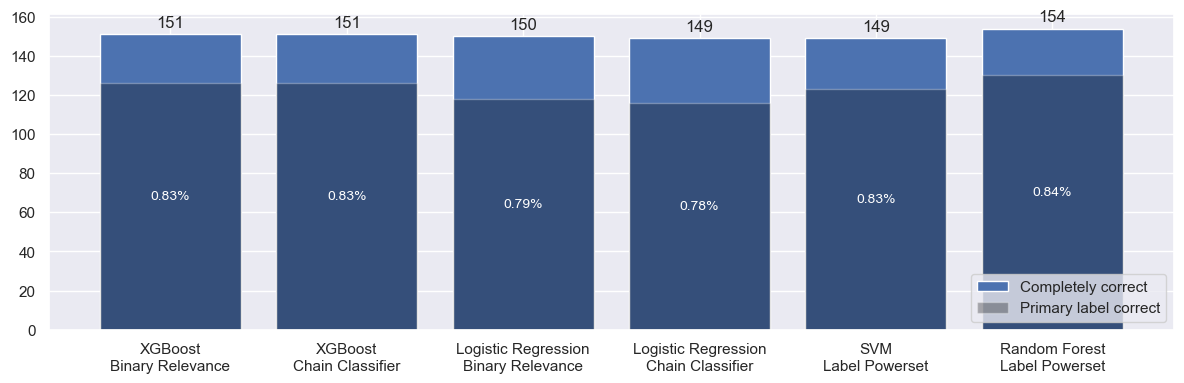

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 6 bars
categories = ['XGBoost\nBinary Relevance', 'XGBoost\nChain Classifier', 'Logistic Regression\nBinary Relevance',
               'Logistic Regression\nChain Classifier', 'SVM\nLabel Powerset', 'Random Forest\nLabel Powerset']
values = [xgb_br_results['primary label correct'], xgb_cc_results['primary label correct'], 
          lr_br_results['primary label correct'], lr_cc_results['primary label correct'], 
          svm_lp_results['primary label correct'], rf_lp_results['primary label correct']]
overlay_values = [xgb_br_results['completelly correct'], xgb_cc_results['completelly correct'], 
                lr_br_results['completelly correct'], lr_cc_results['completelly correct'], 
                svm_lp_results['completelly correct'], rf_lp_results['completelly correct']]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the main bars
main_bars = ax.bar(categories, values, alpha=1, label='Completely correct')

# Create the overlay bars (transparent)
overlay_bars = ax.bar(categories, overlay_values, color='black', alpha=0.3, label='Primary label correct')

# Add labels and title
#ax.set_title('Bar Plot with Transparent Overlay Bars')

# Add height of main bars above them
for bar in main_bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')

# Add specific numbers in the middle of overlaid bars
for category, value, overlay_value in zip(categories, values, overlay_values):
    x = categories.index(category)
    middle_y = (overlay_value) / 2
    ax.annotate("{:.2f}%".format(overlay_value / value), xy=(x, middle_y), xycoords='data',
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', color='white', fontsize=10)

ax.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


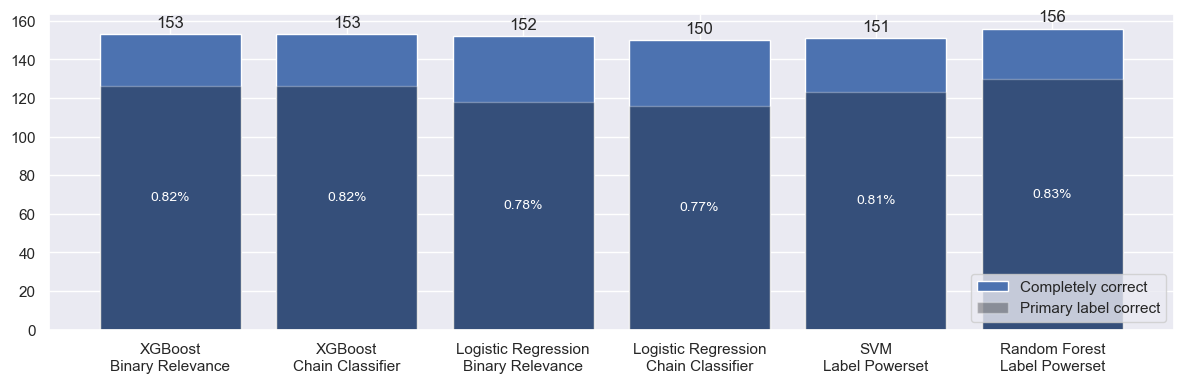

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 6 bars
categories = ['XGBoost\nBinary Relevance', 'XGBoost\nChain Classifier', 'Logistic Regression\nBinary Relevance',
               'Logistic Regression\nChain Classifier', 'SVM\nLabel Powerset', 'Random Forest\nLabel Powerset']
values = [xgb_br_results["p and s and t correcr"], xgb_cc_results["p and s and t correcr"], 
          lr_br_results["p and s and t correcr"], lr_cc_results["p and s and t correcr"], 
          svm_lp_results["p and s and t correcr"], rf_lp_results["p and s and t correcr"]]
overlay_values = [xgb_br_results['completelly correct'], xgb_cc_results['completelly correct'], 
                lr_br_results['completelly correct'], lr_cc_results['completelly correct'], 
                svm_lp_results['completelly correct'], rf_lp_results['completelly correct']]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the main bars
main_bars = ax.bar(categories, values, alpha=1, label='Completely correct')

# Create the overlay bars (transparent)
overlay_bars = ax.bar(categories, overlay_values, color='black', alpha=0.3, label='Primary label correct')

# Add labels and title
#ax.set_title('Bar Plot with Transparent Overlay Bars')

# Add height of main bars above them
for bar in main_bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')

# Add specific numbers in the middle of overlaid bars
for category, value, overlay_value in zip(categories, values, overlay_values):
    x = categories.index(category)
    middle_y = (overlay_value) / 2
    ax.annotate("{:.2f}%".format(overlay_value / value), xy=(x, middle_y), xycoords='data',
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', color='white', fontsize=10)

ax.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


In [44]:
def cmp_statistics_for_two_labelled_samples(predictions, probs, gt_labels, df_multi, X_test_scaled_selected):

    # Check dimensions
    assert predictions.shape == gt_labels.shape

    # Set the original indices
    predictions.set_index(gt_labels.index, inplace=True)
    probs.set_index(gt_labels.index, inplace=True)

    # Get samples's predictions and GTs with only two labels
    preds_two_labels_idx = predictions.sum(axis=1) == 2
    preds_two_labels = predictions[predictions.sum(axis=1) == 2]
    gt_samples_two_labels = gt_labels[gt_labels.sum(axis=1) == 2]

    print("Number of 2-labelled samples from GT test set: ", gt_samples_two_labels.shape[0])
    print("Number of 2-labelled samples from predicted test set: ", preds_two_labels.shape[0])

    # Find the samples with one label that appeared in GT and prediction
    two_labels_overlap_idx = set(gt_samples_two_labels.index).\
        intersection(set(preds_two_labels.index))
    print('Number of samples that overlap:', len(two_labels_overlap_idx))

    # Applying the rank-function to each row of the GT correlation/membership values
    X_corr_test = df_multi.iloc[X_test_scaled_selected.index, -5:]
    ranked_indices = X_corr_test.apply(rank_indices, axis=1)
    ranked_prob_indices = probs.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=X_corr_test.columns, index=X_corr_test.index)
    ranked_prob_df = pd.DataFrame(ranked_prob_indices.values.tolist(), columns=probs.columns, index=probs.index)

    assert ranked_corr_df.shape == gt_labels.shape
    ranked_corr_labelled_df = ranked_corr_df * gt_labels

    assert ranked_prob_df.shape == predictions.shape
    ranked_prob_labelled_df = ranked_prob_df * predictions

    # Find rows with only one label in the predictions DataFrame
    two_labelled_rows = predictions.sum(axis=1) == 2

    # Extract corresponding rows from predictions and GT ranks and GT labels
    ranked_for_double_label = ranked_corr_labelled_df[two_labelled_rows]
    ranked_probs_for_double_label = ranked_prob_labelled_df[two_labelled_rows]
    predictions_df = predictions[two_labelled_rows]
    gt_df = gt_labels[two_labelled_rows]

    # Count how many samples where 1 is in predictions correspond to rank 1 and 2 in correct order
    cnt_with_order_completely_correct = \
        ((ranked_for_double_label == ranked_probs_for_double_label).sum(axis=1) == 5).sum() # [1, 0, 2, 0, 0] == [1, 0, 2, 0, 0] 
    cnt_with_order_partially_correct = \
        ((((ranked_for_double_label == 1) & (ranked_probs_for_double_label == 1)) | \
          ((ranked_for_double_label == 2) & (ranked_probs_for_double_label == 2))).sum(axis=1) == 2).sum() # [1, 3, 2, 0, 0] == [1, 0, 2, 0, 0] 
    cnt_without_order_two_labels = ((predictions_df==gt_df).sum(axis=1) == 5).sum() # [2, 0, 1, 0, 0] == [1, 0, 2, 0, 0] 
    cnt_without_order_two_and_more_labels = ((predictions_df==gt_df).sum(axis=1) >= 4).sum() # [2, 0, 1, 0, 0] == [1, 0, 2, 0, 0] 

    print("\nNumber of samples with completely correct order: ", cnt_with_order_completely_correct)
    print("Number of samples with partially correct order: ", cnt_with_order_partially_correct)
    print("Number of samples correctly predicted in any order for only 2 labels: ", cnt_without_order_two_labels)
    print("Number of samples correctly predicted in any order: ", cnt_without_order_two_and_more_labels)

    # print(ranked_for_double_label, ranked_probs_for_double_label)

    # Count how many samples have same primary (pp), same secondary (ss) labels
    count_doubles_pp = (((ranked_for_double_label == 1) & (ranked_probs_for_double_label == 1))).sum(axis=1).sum()
    count_doubles_ss = (((ranked_for_double_label == 2) & (ranked_probs_for_double_label == 2))).sum(axis=1).sum()

    # Count how many samples have are primary but predicted as secondary (ps)
    count_doubles_ps = (((ranked_for_double_label == 1) & (ranked_probs_for_double_label == 2))).sum(axis=1).sum()

    # Count how many samples have are secondary but predicted as primary (sp)
    count_doubles_sp = (((ranked_for_double_label == 2) & (ranked_probs_for_double_label == 1))).sum(axis=1).sum()

    # Count how many samples have are terciry but predicted as secondary (ts)
    count_doubles_ts = (((ranked_for_double_label == 3) & (ranked_probs_for_double_label == 2))).sum(axis=1).sum()

    # Count how many samples have are terciary but predicted as primary (tp)
    count_doubles_tp = (((ranked_for_double_label == 3) & (ranked_probs_for_double_label == 1))).sum(axis=1).sum()

    # In order to print a confusion matrix st, pt and tt need to be defined too
    count_st, count_pt, count_tt = 0, 0, 0

    # Print confusion matrix
    conf_matrix = np.array([[count_doubles_pp, count_doubles_ps, 0],
                            [count_doubles_sp, count_doubles_ss, 0],
                            [count_doubles_tp, count_doubles_ts, 0]])
    # Define labels
    class_labels = ['Primary', 'Secondary', 'Tertiary']

    # Create a heatmap plot using Seaborn
    # plt.figure(figsize=(4, 3))
    # sns.set(font_scale=0.8)  # Adjust font size
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')

    # Count how many samples are not correctly predicted at all
    count_wrong = ((predictions_df == gt_df).sum(axis=1) <= 3).sum()

    print('\nNumber of samples pp: ', count_doubles_pp)
    print('Number of samples ss: ', count_doubles_ss)
    print('Number of samples ps: ', count_doubles_ps)
    print('Number of samples sp: ', count_doubles_sp)
    print('Number of samples ts: ', count_doubles_ts)
    print('Number of samples tp: ', count_doubles_tp)
    print('\nTotally wrong predicted: ', count_wrong)

    # Compute percentages
    first_perc = cnt_with_order_completely_correct / cnt_with_order_partially_correct
    second_perc = cnt_without_order_two_labels / cnt_without_order_two_and_more_labels

    print('Percentage 1st: ', first_perc)
    print('Percentage 2nd: ', second_perc)

    result = {
        'Completely correct without rank': cnt_without_order_two_labels,
        'Completely correct with rank': cnt_with_order_partially_correct,
        'Not correct': count_wrong,
        'Partially correct': preds_two_labels.shape[0] - cnt_without_order_two_labels - count_wrong,
        'Percentage 1st': first_perc,
        'Percentage 2nd': second_perc,
        'Confusion matrix': conf_matrix
    }
    return result


In [45]:
print('XGBoost with Binary Relevance: ')
xgb_br_res = cmp_statistics_for_two_labelled_samples(predictions=xgb_br_preds, probs=xgb_br_prob_preds, 
                                        gt_labels=y_test_5perc, df_multi=df_multi, 
                                        X_test_scaled_selected=X_test_scaled_selected)

print('XGBoost with Chain Classifier: ')
xgb_cc_res = cmp_statistics_for_two_labelled_samples(predictions=xgb_cc_preds, probs=xgb_cc_prob_preds, 
                                        gt_labels=y_test_5perc, df_multi=df_multi, 
                                        X_test_scaled_selected=X_test_scaled_selected)

print('Logistic Regression with Binary Relevance: ')
lr_br_res = cmp_statistics_for_two_labelled_samples(predictions=lr_br_preds, probs=lr_br_prob_preds, 
                                        gt_labels=y_test_5perc, df_multi=df_multi, 
                                        X_test_scaled_selected=X_test_scaled_selected)

print('Logistic Regression with Chain Classifier: ')
lr_cc_res = cmp_statistics_for_two_labelled_samples(predictions=lr_cc_preds, probs=lr_cc_prob_preds, 
                                        gt_labels=y_test_5perc, df_multi=df_multi, 
                                        X_test_scaled_selected=X_test_scaled_selected)

print('SVM with Label Powerset: ')
svm_lp_res = cmp_statistics_for_two_labelled_samples(predictions=svm_lp_preds, probs=svm_lp_prob_preds, 
                                        gt_labels=y_test_5perc, df_multi=df_multi, 
                                        X_test_scaled_selected=X_test_scaled_selected)

print('Random Forest with Label Powerset: ')
rf_lp_res = cmp_statistics_for_two_labelled_samples(predictions=rf_lp_preds, probs=rf_lp_prob_preds, 
                                        gt_labels=y_test_5perc, df_multi=df_multi, 
                                        X_test_scaled_selected=X_test_scaled_selected)

XGBoost with Binary Relevance: 
Number of 2-labelled samples from GT test set:  148
Number of 2-labelled samples from predicted test set:  142
Number of samples that overlap: 116

Number of samples with completely correct order:  93
Number of samples with partially correct order:  93
Number of samples correctly predicted in any order for only 2 labels:  115
Number of samples correctly predicted in any order:  141

Number of samples pp:  113
Number of samples ss:  94
Number of samples ps:  27
Number of samples sp:  24
Number of samples ts:  0
Number of samples tp:  1

Totally wrong predicted:  1
Percentage 1st:  1.0
Percentage 2nd:  0.8156028368794326
XGBoost with Chain Classifier: 
Number of 2-labelled samples from GT test set:  148
Number of 2-labelled samples from predicted test set:  144
Number of samples that overlap: 115

Number of samples with completely correct order:  98
Number of samples with partially correct order:  98
Number of samples correctly predicted in any order for o

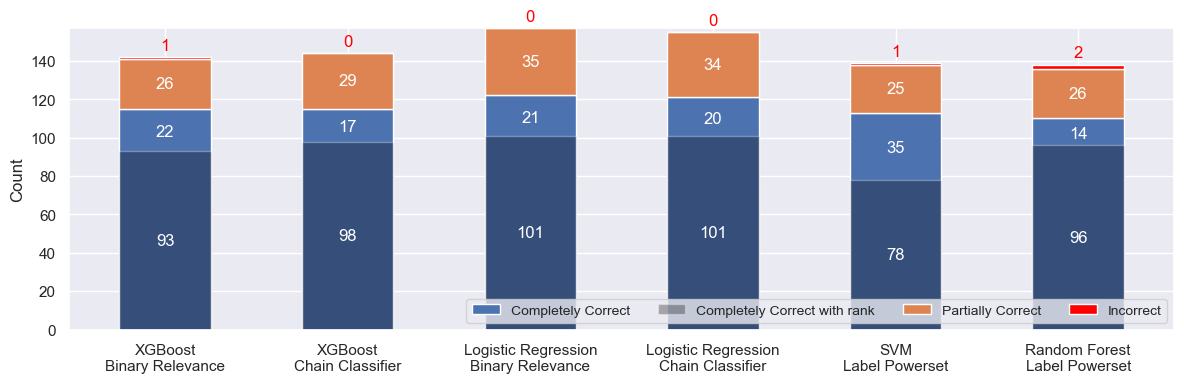

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for three models and their correctness breakdown
models = ['XGBoost\nBinary Relevance', 'XGBoost\nChain Classifier', 'Logistic Regression\nBinary Relevance',
        'Logistic Regression\nChain Classifier', 'SVM\nLabel Powerset', 'Random Forest\nLabel Powerset']
completely_correct = [xgb_br_res['Completely correct without rank'], xgb_cc_res['Completely correct without rank'],
                      lr_br_res['Completely correct without rank'], lr_cc_res['Completely correct without rank'],
                      svm_lp_res['Completely correct without rank'], rf_lp_res['Completely correct without rank']]
completely_correct_with_order = [xgb_br_res['Completely correct with rank'], xgb_cc_res['Completely correct with rank'],
                      lr_br_res['Completely correct with rank'], lr_cc_res['Completely correct with rank'],
                      svm_lp_res['Completely correct with rank'], rf_lp_res['Completely correct with rank']]
partially_correct = [xgb_br_res['Partially correct'], xgb_cc_res['Partially correct'],
                      lr_br_res['Partially correct'], lr_cc_res['Partially correct'],
                      svm_lp_res['Partially correct'], rf_lp_res['Partially correct']]
incorrect = [xgb_br_res['Not correct'], xgb_cc_res['Not correct'],
            lr_br_res['Not correct'], lr_cc_res['Not correct'],
            svm_lp_res['Not correct'], rf_lp_res['Not correct']]

# Create positions for bars
bar_width = 0.5
index = np.arange(len(models))

# Create the figure and axis
fig, ax = plt.subplots()

# Create stacked bars
ax.bar(index, completely_correct, width=bar_width, label='Completely Correct')
ax.bar(index, completely_correct_with_order, width=bar_width, label='Completely Correct with rank', color='black', alpha=0.3)
ax.bar(index, partially_correct, width=bar_width, label='Partially Correct', bottom=completely_correct)
ax.bar(index, incorrect, width=bar_width, label='Incorrect', bottom=np.array(completely_correct) + np.array(partially_correct), color='red')

# Add labels and title
ax.set_ylabel('Count')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend(ncol=4, loc='lower right', fontsize=10)

# Add values in the middle of each part
for i, (cc, cco, pc, ic) in enumerate(zip(completely_correct, completely_correct_with_order, partially_correct, incorrect)):
    x = index[i]
    y_cco = cco / 2
    y_cc = cco + (cc-cco) / 2 - 1
    y_pc = cc + pc / 2
    y_ic = cc + pc + ic + 6
    ax.text(x, y_cco, str(cco), ha='center', va='center', color='white', fontsize=12)
    ax.text(x, y_cc, str(cc-cco), ha='center', va='center', color='white', fontsize=12)
    ax.text(x, y_pc, str(pc), ha='center', va='center', color='white', fontsize=12)
    ax.text(x, y_ic, str(ic), ha='center', va='center', color='red', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


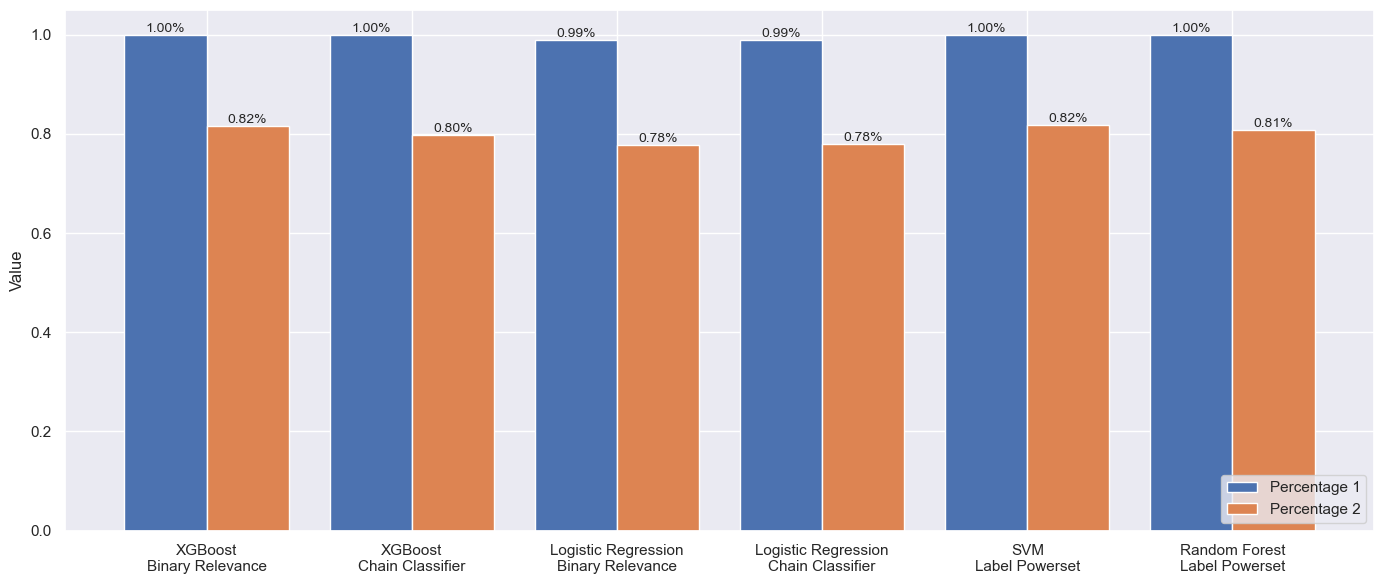

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for six models with two bars per model
models = ['XGBoost\nBinary Relevance', 'XGBoost\nChain Classifier', 'Logistic Regression\nBinary Relevance',
        'Logistic Regression\nChain Classifier', 'SVM\nLabel Powerset', 'Random Forest\nLabel Powerset']
perc_1 = [xgb_br_res['Percentage 1st'], xgb_cc_res['Percentage 1st'],
                      lr_br_res['Percentage 1st'], lr_cc_res['Percentage 1st'],
                      svm_lp_res['Percentage 1st'], rf_lp_res['Percentage 1st']]
perc_2 = [xgb_br_res['Percentage 2nd'], xgb_cc_res['Percentage 2nd'],
                      lr_br_res['Percentage 2nd'], lr_cc_res['Percentage 2nd'],
                      svm_lp_res['Percentage 2nd'], rf_lp_res['Percentage 2nd']]

# Create positions for the grouped bars
bar_width = 0.4
index = np.arange(len(models))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Create grouped bars for each model
ax.bar(index - bar_width / 2, perc_1, width=bar_width, label='Percentage 1')
ax.bar(index + bar_width / 2, perc_2, width=bar_width, label='Percentage 2')

# Add labels and title
ax.set_ylabel('Value')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend(loc='lower right')

# Add values on top of each bar
for i, (val1, val2) in enumerate(zip(perc_1, perc_2)):
    x = index[i]
    ax.text(x - bar_width / 2, val1 , "{:.2f}%".format(val1), ha='center', va='bottom', fontsize=10)
    ax.text(x + bar_width / 2, val2 , "{:.2f}%".format(val2), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


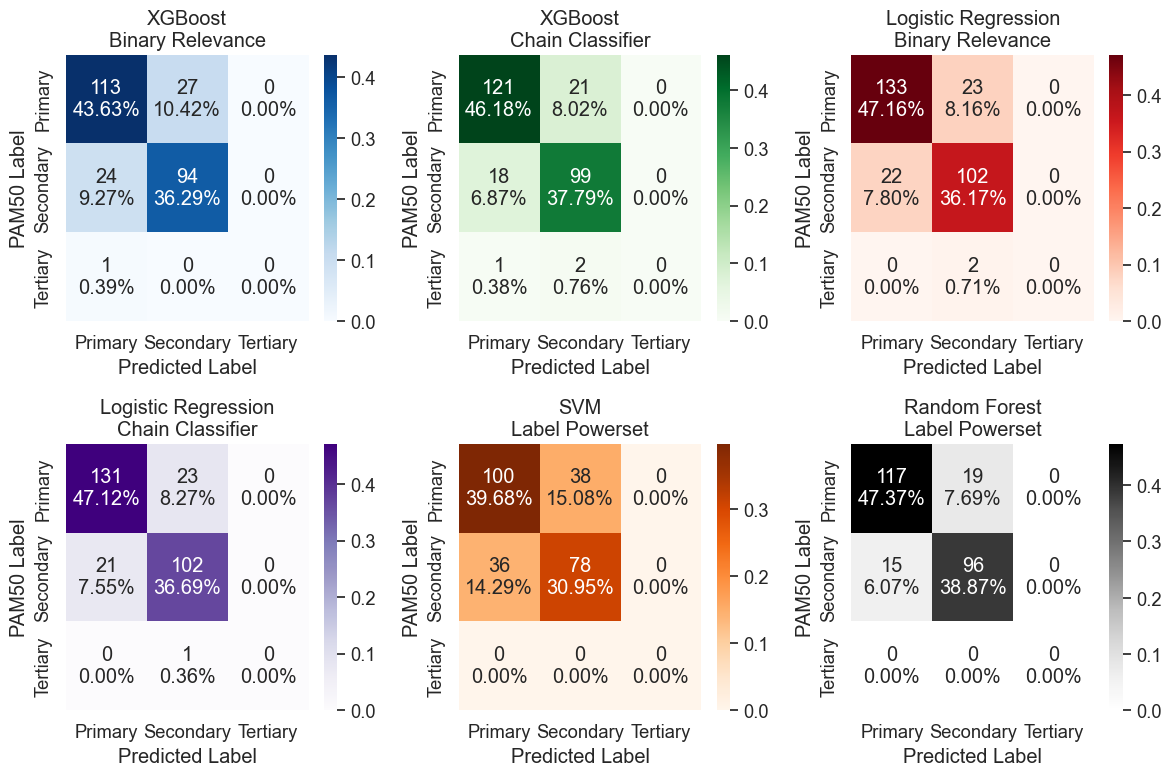

In [66]:
# Confusuion matrix
model_names = ['XGBoost\nBinary Relevance', 'XGBoost\nChain Classifier', 'Logistic Regression\nBinary Relevance',
        'Logistic Regression\nChain Classifier', 'SVM\nLabel Powerset', 'Random Forest\nLabel Powerset']
conf_matrices = [xgb_br_res['Confusion matrix'], xgb_cc_res['Confusion matrix'],
                lr_br_res['Confusion matrix'], lr_cc_res['Confusion matrix'],
                svm_lp_res['Confusion matrix'], rf_lp_res['Confusion matrix']]

# Use the deep color palette from Seaborn
colors = ['Blues_r', 'Greens_r', 'Reds_r', 'Purples_r', 'Oranges_r', 'Greys_r']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Loop through each model and plot the confusion matrix in a specific color
for i, (conf_matrix, model_name, color) in enumerate(zip(conf_matrices, model_names, colors)):

    row = i // 3
    col = i % 3

    # Normalize confusion matrix
    conf_matrix_norm = conf_matrix / conf_matrix.sum().sum()

    group_counts = ['{0:0.0f}'.format(value) for value in
                conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        conf_matrix_norm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)

    # Create a reversed colormap
    cmap = sns.color_palette(color, as_cmap=True).reversed()
    
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix_norm, annot=labels, fmt='', cmap=cmap, ax=axes[row, col])

    # Add absolute numbers as subannotations
    

    axes[row, col].set_title(model_name)
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_ylabel('PAM50 Label')
    axes[row, col].set_xticklabels(['Primary', 'Secondary', 'Tertiary'])
    axes[row, col].set_yticklabels(['Primary', 'Secondary', 'Tertiary'])

plt.tight_layout()
